In [1]:
import numpy as np
import cvxpy as cp
import os
import pickle as pkl
import json
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture

In [2]:
dataset_path = "F:/MASC/shot_processed_dataset"
metadata_path = os.path.join(*[dataset_path, "metadata.json"])

# Create The classes that generate the prior neck angle from gaze angle

In [3]:
class Heuristic_decomposition_azimuth:
    # this is within version 2p2
    def __init__(self, assym=0):
        # assym = 0: symmetrical,
        # assym = 1: more neck contribution at positive angle (right)
        # assym = 2: more neck contribution at negative angle (left)
        self.assym = assym
        # here the percentage the is the percentage of neck contribution
        self.sym_pts_low = [[-90, 0.3], [-50, 0.1], [-25, 0.05], [-10, 0.05], [0, 0], [10, 0.05],
        [25, 0.05], [50, 0.1], [90, 0.3]]
        self.sym_pts_mid = [[-90, 0.6], [-50, 1], [-25, 0.75], [-10, 0.4], [0, 0], [10, 0.4],
                            [25, 0.75], [50, 1], [90, 0.6]]
        self.sym_pts_high = [[-90, 0.6], [-50, 1], [-25, 0.9], [-10, 0.5], [0, 0], [10, 0.5],
        [25, 0.9], [50, 1], [90, 0.6]]

    def get_y(self, p1, p2, x):
        return (x - p1[0]) / (p2[0] - p1[0]) * (p2[1] - p1[1]) + p1[1]

    def decompose(self, alpha, neck_enthusiasm):
        # alpha is a single float point value, should be the degree of angle at the azimuth plane

        # if alpha is an extreme angle, then we just fix neck contribution at 60%
        if abs(alpha) >= 90:
            neck_alpha = 0.6 * alpha
            eye_alpha = alpha - neck_alpha
            return eye_alpha, neck_alpha

        # otherwise, we find the right bin and use the corresponding line
        for i in range(1, len(self.sym_pts_low)):
            if self.sym_pts_low[i][0] >= alpha:
                bin0 = i - 1
                bin1 = i
                break
        if neck_enthusiasm >= 0.5:
            factor = 2.0 * (neck_enthusiasm - 0.5)
            pt0 = np.array([self.sym_pts_low[bin0][0],
                            self.sym_pts_high[bin0][1] * factor + (1.0 - factor) * self.sym_pts_mid[bin0][1]])
            pt1 = np.array([self.sym_pts_low[bin1][0],
                            self.sym_pts_high[bin1][1] * factor + (1.0 - factor) * self.sym_pts_mid[bin1][1]])
        else:
            factor = 2.0 * neck_enthusiasm
            pt0 = np.array([self.sym_pts_low[bin0][0],
                            self.sym_pts_mid[bin0][1] * factor + (1.0 - factor) *  self.sym_pts_low[bin0][1]])
            pt1 = np.array([self.sym_pts_low[bin1][0],
                            self.sym_pts_mid[bin1][1] * factor + (1.0 - factor) *  self.sym_pts_low[bin1][1]])
        ratio = self.get_y(pt0, pt1, alpha)
        neck_alpha = alpha * ratio
        eye_alpha = alpha - neck_alpha
        return eye_alpha, neck_alpha

    def decompose_sequence(self, alpha_list):
        EIH_arr = []
        head_arr = []
        for i in range(0, len(alpha_list)):
            alpha = alpha_list[i]
            current_break_down = self.decompose(alpha)
            EIH_arr.append(current_break_down[0])
            head_arr.append(current_break_down[1])
        return EIH_arr, head_arr
class Heuristic_decomposition_elevation:
    def __init__(self, p1=None, p2=None, p3=None, p4=None):
        # here the percentage the is the percentage of neck contribution
        self.p0 = [90, 0.5]
        self.p1 = [0, 0.1]
    def get_y(self, p1, p2, x):
        return (x - p1[0])/(p2[0] - p1[0]) * (p2[1] - p1[1]) + p1[1]
    def decompose(self, alpha, neck_contribution):
        # alpha is a single float point value, should be the degree of angle at the azimuth plane
        ab_alpha = abs(alpha)
        neck_alpha = 0.25 * ab_alpha * neck_contribution
        eye_alpha = ab_alpha - neck_alpha
        if alpha >= 0:
            neck_alpha = 0.25 * ab_alpha * neck_contribution
            eye_alpha = ab_alpha - neck_alpha
            return eye_alpha, neck_alpha
        else:
            neck_alpha = 0.6 * ab_alpha * neck_contribution
            eye_alpha = ab_alpha - neck_alpha
            return -eye_alpha, -neck_alpha
    def decompose_sequence(self, alpha_list):
        EIH_arr = []
        head_arr = []
        for i in range(0, len(alpha_list)):
            alpha = alpha_list[i]
            current_break_down = self.decompose(alpha)
            EIH_arr.append(current_break_down[0])
            head_arr.append(current_break_down[1])
        return EIH_arr, head_arr

# Geometry helper functions

In [4]:
def rotation_angles_frome_positions(arr):
    """
    converts an array of positions to an array of rotation angles (azimuth, elevation)
    centered at the origin, where:
        azimuth: +right,-left
        elevation: +up,-down
    here we assume that the input vectors are in world coordinates
    :param arr: array with shape (N, 3)
    :return: array with shape (N, 2)
    """
    # F: arr (N, 3) -> arr (N, 2) or arr (3, ) -> (2, )
    # in the output is in the convention of (azimuth, elevation)
    if len(arr.shape) == 2:
        mag = np.sqrt(np.sum(arr * arr, axis=1, keepdims=True))
        out = arr / mag
        out[:, 0] = np.arcsin(out[:, 0])
        out[:, 1] = np.arcsin(out[:, 1])
        return out[:, 0:2] * 180 / np.pi
    else:
        mag = np.sqrt(np.sum(arr * arr))
        out = arr / mag
        out[0] = np.arcsin(out[0])
        out[1] = np.arcsin(out[1])
        return out[0:2] * 180 / np.pi
def directions_from_rotation_angles(arr, magnitudes):
    """
    converts an array of rotation angles (in degrees) to an array of positions (x, y, z)
    :param arr: array of rotations (centered at the origins) shape of (N, 2)
    :param magnitudes: magnitude of the direction vector, shape of (N, 1)
    :return: array with shape of (N, 3)
    """
    out = np.ones((arr.shape[0], 3))
    
    x = magnitudes * np.sin(arr[:, 0]/ 180 * np.pi) * np.cos(arr[:, 1]/ 180 * np.pi)
    y = magnitudes * np.sin(arr[:, 0]/ 180 * np.pi) * np.sin(arr[:, 1]/ 180 * np.pi)
    z = magnitudes * np.cos(arr[:, 1]/ 180 * np.pi)
    out[:, 0] = x
    out[:, 1] = y
    out[:, 2] = z    
    return out

# The optimization model

In [53]:
def get_optimizer(weights):
    def optimize_for_head_gaze_breakdown(gaze_duration, list_of_gaze_positions, listener_position):
        # listener bias is the tendency of looking at the listner
        listener_angle = listener_position
        listener_angle_expand = listener_position
        # get the angle to be in degrees
        gaze_angles = list_of_gaze_positions
        azi_decomp = Heuristic_decomposition_azimuth()
        ele_decomp = Heuristic_decomposition_elevation()
        # motion prior
        motion_priors = [] 
        # get the prior angles one by one
        prior_head_angles = []
        for i in range(0, gaze_angles.shape[0]):
            prev_azi = gaze_angles[max(0, i-1), 0]
            azi_angle = gaze_angles[i, 0]
            azi_gaze, azi_head = azi_decomp.decompose(azi_angle, 0.3)
            prev_ele = gaze_angles[max(0, i-1), 1]
            ele_angle = gaze_angles[i, 1]
            ele_gaze, ele_head = ele_decomp.decompose(ele_angle, 0.5)
            # make the character look down less if they are looking down
            if ele_head < 0:
                ele_head = ele_head * 0.3
            new_head_angles = np.array([[azi_head, ele_head]])
            prior_head_angles.append((new_head_angles))

        prior_head_angles = np.concatenate(prior_head_angles, axis=0) - listener_position
        gaze_angles = gaze_angles - listener_angle
        # center bias is the tendency of looking at the center
        center_bias_head_angles = np.zeros((prior_head_angles.shape))

        # solve for the neck based on the simple optimization
        solved_angles = []
        for i in range(0, prior_head_angles.shape[0]):
            gaze_time = gaze_duration[i]
            neck_angle_ele = cp.Variable(1)
            neck_angle_azi = cp.Variable(1)
            # optimize for neck angle azi
            # objective = cp.Minimize(min(gaze_time, 1) * (neck_angle_azi - prior_head_angles[i, 0]) ** 2
            #                         + (neck_angle_azi - listener_angle[0])**2)
            objective = cp.Minimize(weights[0] * (neck_angle_azi - prior_head_angles[i, 0]) ** 2 +
                                    weights[1] * min(gaze_time, 1.5) * (neck_angle_azi - gaze_angles[i, 0]) ** 2 +
                                    weights[2] * max(1.5 - gaze_time, 0.00001) * (neck_angle_azi) ** 2)
            problem = cp.Problem(objective, [])
            opt = problem.solve()
            # optimize for neck angle elevation
            # objective = cp.Minimize(min(gaze_time, 1) * (neck_angle_ele - prior_head_angles[i, 1]) ** 2
            #                         + (neck_angle_ele - listener_angle[1])**2)
            objective = cp.Minimize(weights[0] * (neck_angle_ele - prior_head_angles[i, 1]) ** 2 +
                                    weights[1] * min(gaze_time, 1.5) * (neck_angle_ele - gaze_angles[i, 1]) ** 2 +
                                    weights[2] * max(1.5 - gaze_time, 0) * (neck_angle_ele) ** 2)
            problem = cp.Problem(objective, [])
            opt = problem.solve()
            # solved_angles.append(np.array([[prior_head_angles[i, 0]+listener_angle[0], prior_head_angles[i, 1]+listener_angle[0]]]))
            solved_angles.append(np.array([[neck_angle_azi.value[0]+listener_angle_expand[i][0], neck_angle_ele.value[0]+listener_angle_expand[i][1]]]))
            # solved_angles.append(np.array([[listener_angle[0], listener_angle[0]]]))
        solved_angles = np.concatenate(solved_angles, axis = 0)
        return solved_angles
    return optimize_for_head_gaze_breakdown

# Functions for loading data

In [54]:
def load_gaze_neck_data(dataset_path, file_name, fps):
    gaze_path = os.path.join(*[dataset_path, "gaze", file_name+".pkl"])
    head_path = os.path.join(*[dataset_path, "head", file_name+".pkl"])
    gaze_data = None
    head_data = None
    with open(gaze_path, "rb") as f:
        gaze_data = pkl.load(f)
    with open(head_path, "rb") as f:
        head_data = pkl.load(f)[:, :2]
    ts = np.arange(0, head_data.shape[0]) / fps
    mixture = GaussianMixture(int(np.minimum(8, gaze_data.shape[0]))).fit(gaze_data[:], )
    mix = mixture.predict_proba(gaze_data)
    # get cluster heads
    mixture_centers = mixture.means_
    # find the index of the most likely target
    most_likely_target = np.argmax(np.sum(mix, axis=0))
    # find the most likely look at point
    gaze_mean = mixture_centers[most_likely_target]

    mixture = GaussianMixture(int(np.minimum(8, head_data.shape[0]))).fit(head_data[:], )
    mix = mixture.predict_proba(head_data)
    # get cluster heads
    mixture_centers = mixture.means_
    # find the index of the most likely target
    most_likely_target = np.argmax(np.sum(mix, axis=0))
    # find the most likely look at point
    head_mean = mixture_centers[most_likely_target]

    gaze_duration_data, head_duration_data = dispersion_filtering(ts, gaze_data, head_data)
    return gaze_duration_data, head_duration_data, gaze_mean, head_mean
def dispersion_filtering(x, y, y_neck, dispersion_threshold = 6, duraiton_threshold=0.3):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    fixations_neck = []
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            centroid_neck = np.mean(y_neck[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_neck.append([centroid_neck[0], centroid_neck[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    fixations_neck = np.array(fixations_neck)
    return fixations, fixations_neck

# Optimize with data

In [83]:
from itertools import product
def hyperparameter_search(model, hyperparameters, duration, gaze, neck, neutral):
    """
    Perform a hyperparameter search using grid search.

    Parameters:
    model (object): A machine learning model object with a .fit method.
    hyperparameters (dict): A dictionary of hyperparameters to search over.
    X (array-like): The input data for the model.
    y (array-like): The target data for the model.

    Returns:
    best_params (dict): The best hyperparameters found.
    """
    # Get all combinations of hyperparameters
    all_params = product(*hyperparameters.values())

    # Initialize variables to keep track of best model performance
    best_score = float('-inf')
    best_params = None
    values = []
    # Loop over all hyperparameter combinations
    rt_params = []
    for params in all_params:
        # Set hyperparameters for the model
        model_i = get_optimizer(params+params)
        output = model_i(duration, gaze, neutral)
        
        # Calculate model performance using cross-validation
        mean_score = np.linalg.norm(output - neck, axis=1).mean()
        # Update best score and parameters if current score is better
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
        values.append(mean_score)
        rt_params.append([params[0], params[1], params[2], mean_score])
        print(rt_params[-1])
    print(best_params, best_score)
    return best_params, rt_params

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grid_search(results, N):
    """
    Plot the results of a grid search on N 2D grids using seaborn.

    Parameters:
    results (list): A list of tuples in the format [(param1, param2, param3), value].
    N (int): The number of values for the first parameter.

    Returns:
    None
    """
    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=['w_prior', 'w_gaze', 'w_neutral', 'value'])
    
    # Loop over the values of the first parameter
    for i in [1, 2]:
        # Filter the DataFrame to select the rows with the current value of the first parameter
        df_i = df[df['w_prior'] == i]
        
        # Pivot the filtered DataFrame to create a 2D grid
        # grid = df_i.pivot('param2', 'param3', 'value')
        grid = df_i
        # Create a heatmap plot of the grid
        ax = sns.heatmap(grid, annot=True, fmt=".3f", linewidths=.5, cmap='coolwarm')
        
        # Set the plot title and labels
        ax.set_title(f'Grid Search Results (w_prior={i})')
        ax.set_xlabel('w_neutral')
        ax.set_ylabel('w_gaze')
        
        # Show the plot
        plt.show()

In [99]:
hyperparameters = {
    'w_prior': [1],
    'w_target': [0],
    'w_neutral': [0],
}

with open(metadata_path, "r") as f:
    metadata = json.load(f)["data"]
data = [109, 200]
for i in range(109, len(metadata)):
    file_name = metadata[i]["name"]
    fps = metadata[i]["fps"]
    gaze, head, neutral_gaze, neutral_head = load_gaze_neck_data(dataset_path, file_name, fps)
    ts = np.arange(gaze.shape[0]) / fps
    neutral = np.tile(np.expand_dims(neutral_head, axis=0), [gaze.shape[0], 1])
    print("just gaze: ", np.linalg.norm(gaze - head, axis=1).mean())
    print("just neutral: ", np.linalg.norm(gaze[:, :2] - neutral, axis=1).mean())
    # here we assume that neutral head is where the other person is facing
    __, output = hyperparameter_search(get_optimizer, hyperparameters, gaze[:, 2], gaze[:, :2], head[:, :2], neutral)
    A[23094]

just gaze:  16.03571379681066
just neutral:  24.248858514914907
[1, 0, 0, 11.301290216709038]
(1, 0, 0) 11.301290216709038


NameError: name 'A' is not defined

In [103]:
hyperparameters = {
    'w_prior': [1, 2],
    'w_target': [0.1, 0.2, 0.3, 0.5],
    'w_neutral': [0.1, 0.2, 0.3, 0.5],
}

with open(metadata_path, "r") as f:
    metadata = json.load(f)["data"]
data = [109, 200]
for i in range(109, len(metadata)):
    file_name = metadata[i]["name"]
    fps = metadata[i]["fps"]
    gaze, head, neutral_gaze, neutral_head = load_gaze_neck_data(dataset_path, file_name, fps)
    ts = np.arange(gaze.shape[0]) / fps
    neutral = np.tile(np.expand_dims(neutral_head, axis=0), [gaze.shape[0], 1])
    print("just gaze: ", np.linalg.norm(gaze - head, axis=1).mean())
    print("just neutral: ", np.linalg.norm(gaze[:, :2] - neutral, axis=1).mean())
    # here we assume that neutral head is where the other person is facing
    __, output = hyperparameter_search(get_optimizer, hyperparameters, gaze[:, 2], gaze[:, :2], head[:, :2], neutral)
    A[23094]
    

just gaze:  16.03571379681066
just neutral:  24.263330503415933
[1, 0.1, 0.1, 10.939443891948905]
[1, 0.1, 0.2, 10.943871624845398]
[1, 0.1, 0.3, 10.975136808123624]
[1, 0.1, 0.5, 11.081607657026963]
[1, 0.2, 0.1, 11.240013175197644]
[1, 0.2, 0.2, 11.24839215189526]
[1, 0.2, 0.3, 11.282438281764602]
[1, 0.2, 0.5, 11.387337042635366]
[1, 0.3, 0.1, 11.598882612135531]
[1, 0.3, 0.2, 11.609137050141886]
[1, 0.3, 0.3, 11.643241748596786]
[1, 0.3, 0.5, 11.746994861658248]
[1, 0.5, 0.1, 12.317110026796518]
[1, 0.5, 0.2, 12.333362805593573]
[1, 0.5, 0.3, 12.370522121019771]
[1, 0.5, 0.5, 12.476753693806533]
[2, 0.1, 0.1, 10.935769621006706]
[2, 0.1, 0.2, 10.91582749027318]
[2, 0.1, 0.3, 10.9177555242611]
[2, 0.1, 0.5, 10.948948336923204]
[2, 0.2, 0.1, 10.963777034839621]
[2, 0.2, 0.2, 10.939443891948905]
[2, 0.2, 0.3, 10.936440547446626]
[2, 0.2, 0.5, 10.957427464897155]
[2, 0.3, 0.1, 11.092823898355144]
[2, 0.3, 0.2, 11.070000234064254]
[2, 0.3, 0.3, 11.067982462022988]
[2, 0.3, 0.5, 11.09039

NameError: name 'A' is not defined

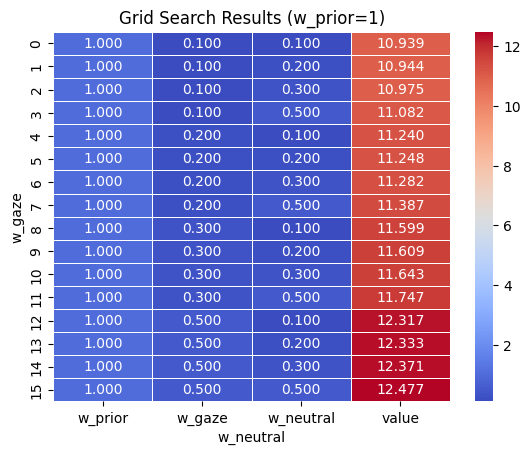

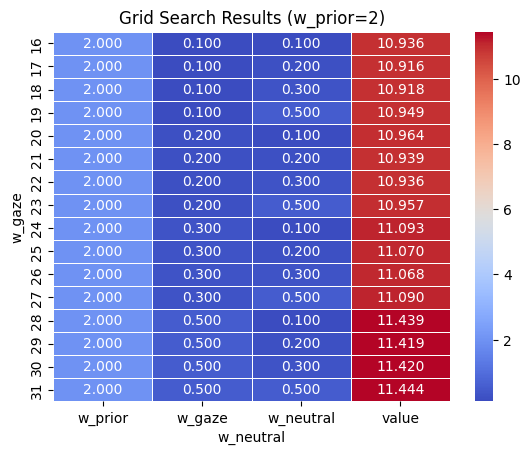

In [104]:
plot_grid_search(output, 2)